# Overview

- This note book is based on https://www.kaggle.com/khoongweihao/autonomous-driving-epoch-on-fire-resnext50. Thank you so mush!


# Experimental Results

- 10 epochs: 0.047 public LB score
[model=resnext50-ep10-0.047.pth]
- loading model + 0 spoch -> 0.015 score
- loading model + 1 epoch -> 0.033 score
- loading model + 3 epoch -> 0.032 score
- loading model + 4 epoch -> 0.046 score

 1 epoch took 1+ hours so in version 2 i will try for 8 epoches


**imports**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
#from tqdm import tqdm_notebook as tqdm
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import os
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from tqdm.auto import tqdm as tq
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms, utils

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import sqrt, acos, pi, sin, cos
from scipy.spatial.transform import Rotation as R
from sklearn.metrics import average_precision_score
from multiprocessing import Pool

import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
import gc

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import sqrt, acos, pi, sin, cos
from scipy.spatial.transform import Rotation as R
from sklearn.metrics import average_precision_score
from multiprocessing import Pool


PATH = '../input/pku-autonomous-driving/'
os.listdir(PATH)

/home/atsushi_kunimatsu/anaconda3/envs/pt/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """


['test_masks',
 'sample_submission.csv',
 'test_images',
 'train.csv',
 'train_masks',
 'camera',
 'car_models_json',
 'car_models',
 'train_images']

In [2]:
import subprocess

cmd = 'ls -l ../input/modelresnext50ep10/resnext50-ep10-0.047.pth*'
process = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                           shell=True).communicate()[0]).decode('utf-8')
print('splited models:\n'+process)

!rm -f './resnext50-ep10-0.047.pth'
subprocess.call('cat ../input/modelresnext50ep10/resnext50-ep10-0.047.pth* >> ./resnext50-ep10-0.047.pth', shell=True)

cmd = 'ls -l ./resnext50-ep10-0.047.pth'
process = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                           shell=True).communicate()[0]).decode('utf-8')
print('concatinated models:\n'+process)

splited models:
-rw-rw-r-- 1 atsushi_kunimatsu atsushi_kunimatsu 50000000 Jan 17 02:03 ../input/modelresnext50ep10/resnext50-ep10-0.047.pth.00
-rw-rw-r-- 1 atsushi_kunimatsu atsushi_kunimatsu 50000000 Jan 17 02:03 ../input/modelresnext50ep10/resnext50-ep10-0.047.pth.01
-rw-rw-r-- 1 atsushi_kunimatsu atsushi_kunimatsu 50000000 Jan 17 02:03 ../input/modelresnext50ep10/resnext50-ep10-0.047.pth.02
-rw-rw-r-- 1 atsushi_kunimatsu atsushi_kunimatsu 10098233 Jan 17 02:03 ../input/modelresnext50ep10/resnext50-ep10-0.047.pth.03

concatinated models:
-rw-rw-r-- 1 atsushi_kunimatsu atsushi_kunimatsu 160098233 Jan 17 04:50 ./resnext50-ep10-0.047.pth



In [3]:
## Constants
SWITCH_LOSS_EPOCH = 5
print(torch.__version__) 

1.3.1


# Load data

In [4]:
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'sample_submission.csv')
bad_list = ['ID_1a5a10365', # broken
'ID_1db0533c7', # too white
'ID_53c3fe91a', # too white
'ID_408f58e9f', # broken
'ID_4445ae041', # too white
'ID_bb1d991f6', # broken
'ID_c44983aeb', # broken
'ID_f30ebe4d4', # too white
'ID_4d238ae90'  # broken
           ]
train = train.loc[~train['ImageId'].isin(bad_list)]
# From camera.zip
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)
camera_matrix_inv = np.linalg.inv(camera_matrix)

train.head()

ImageId                                   PredictionString
0  ID_8a6e65317  16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1  ID_337ddc495  66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2  ID_a381bf4d0  43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3  ID_7c4a3e0aa  43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4  ID_8b510fad6  37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...

**ImageId** column contains names of images:

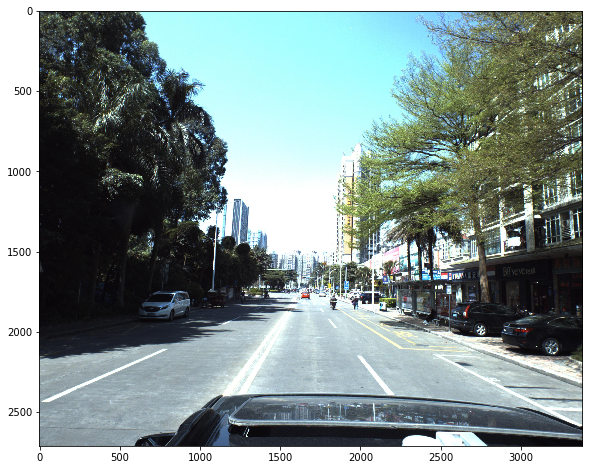

In [5]:
def imread(path, fast_mode=False):
    img = cv2.imread(path)
    if not fast_mode and img is not None and len(img.shape) == 3:
        img = np.array(img[:, :, ::-1])
    return img

img = imread(PATH + 'train_images/ID_8a6e65317' + '.jpg')
IMG_SHAPE = img.shape

plt.figure(figsize=(15,8))
plt.imshow(img);

dropped bad images


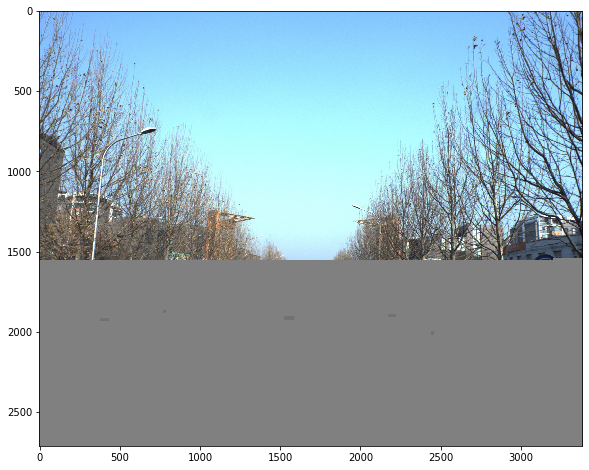

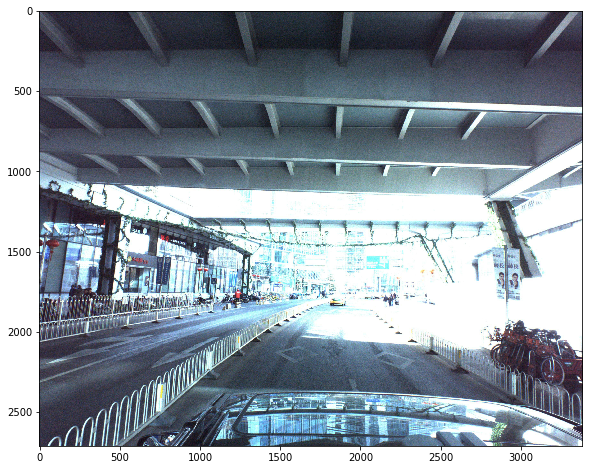

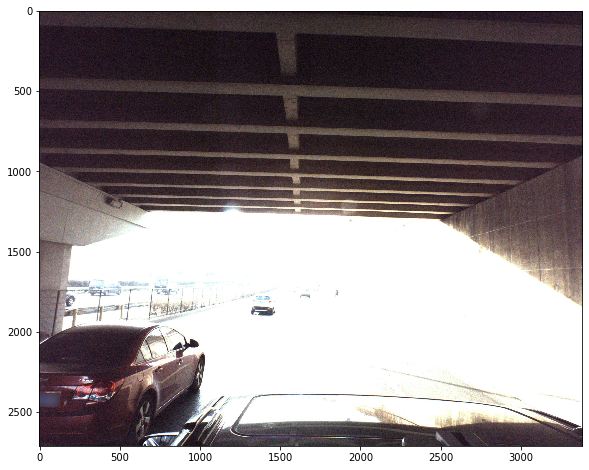

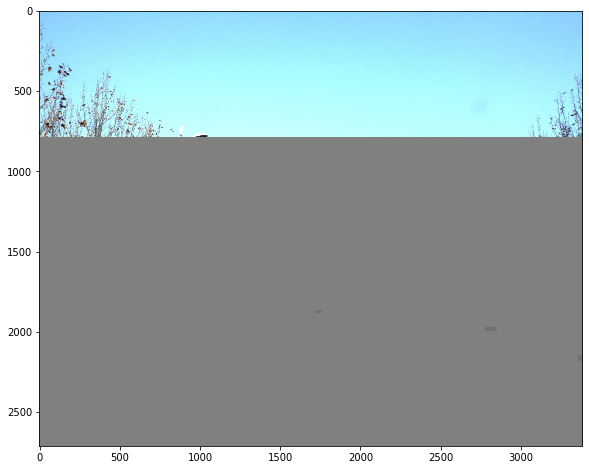

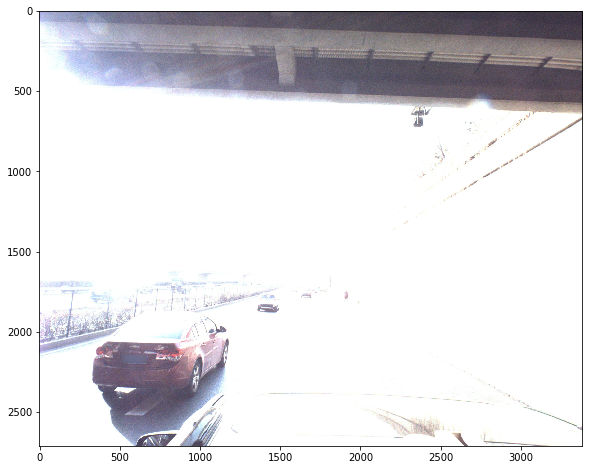

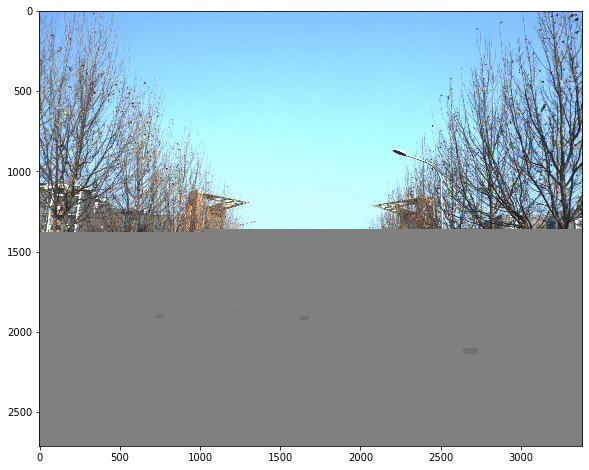

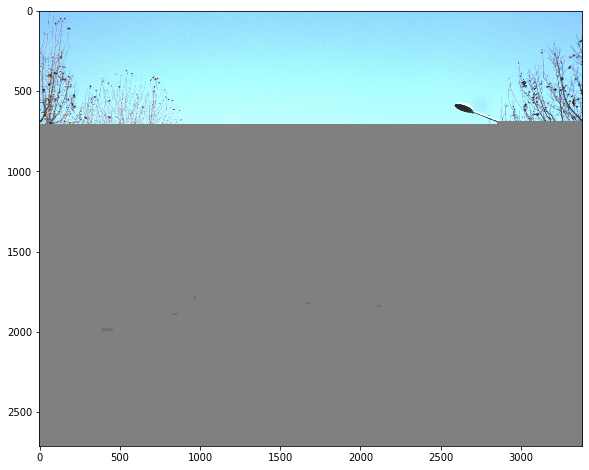

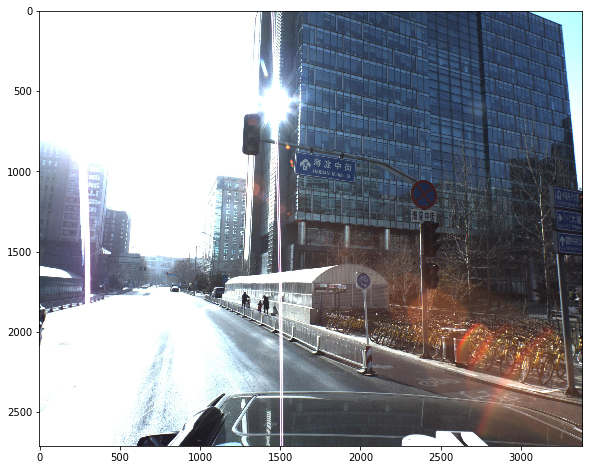

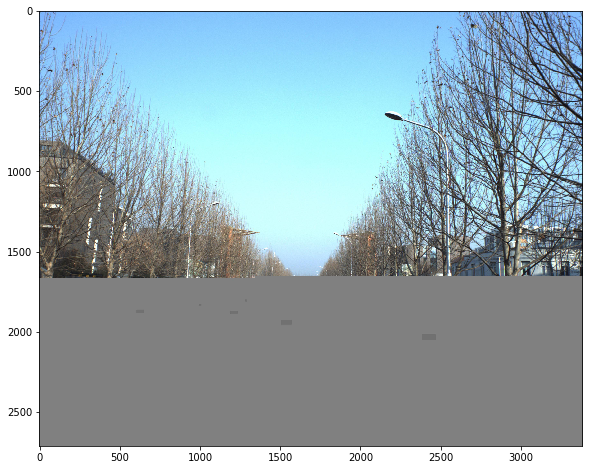

In [6]:
# display bad images
print('dropped bad images')
for bad_img in bad_list:
    img = imread(PATH + 'train_images/' + bad_img + '.jpg')
    plt.figure(figsize=(15,8))
    plt.imshow(img);

In [7]:
def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

In [8]:
inp = train['PredictionString'][0]
print('Example input:\n', inp)
print()
print('Output:\n', str2coords(inp))

Example input:
 16 0.254839 -2.57534 -3.10256 7.96539 3.20066 11.0225 56 0.181647 -1.46947 -3.12159 9.60332 4.66632 19.339 70 0.163072 -1.56865 -3.11754 10.39 11.2219 59.7825 70 0.141942 -3.1395 3.11969 -9.59236 5.13662 24.7337 46 0.163068 -2.08578 -3.11754 9.83335 13.2689 72.9323

Output:
 [{'id': 16, 'yaw': 0.254839, 'pitch': -2.57534, 'roll': -3.10256, 'x': 7.96539, 'y': 3.20066, 'z': 11.0225}, {'id': 56, 'yaw': 0.181647, 'pitch': -1.46947, 'roll': -3.12159, 'x': 9.60332, 'y': 4.66632, 'z': 19.339}, {'id': 70, 'yaw': 0.163072, 'pitch': -1.56865, 'roll': -3.11754, 'x': 10.39, 'y': 11.2219, 'z': 59.7825}, {'id': 70, 'yaw': 0.141942, 'pitch': -3.1395, 'roll': 3.11969, 'x': -9.59236, 'y': 5.13662, 'z': 24.7337}, {'id': 46, 'yaw': 0.163068, 'pitch': -2.08578, 'roll': -3.11754, 'x': 9.83335, 'y': 13.2689, 'z': 72.9323}]


# Data distributions

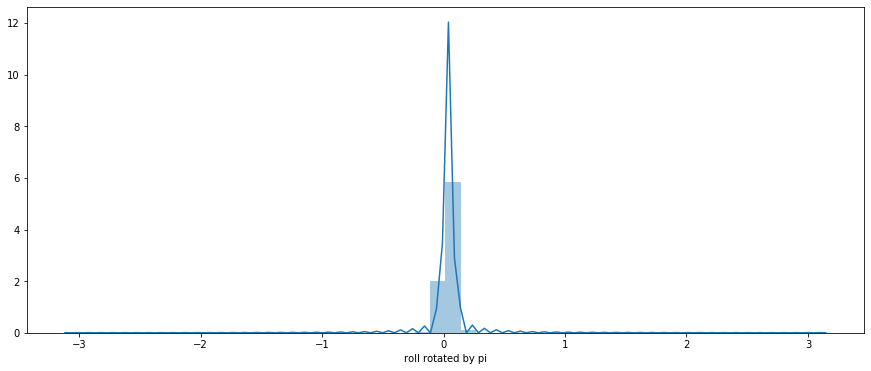

In [9]:
def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x

def add_number_of_cars(df):
    """df - train or test"""
    df['numcars'] = [int((x.count(' ')+1)/7) for x in df['PredictionString']]
    return df

plt.figure(figsize=(15,6))
sns.distplot(reduce(lambda a, b: a + b, [[rotate(c['roll'], np.pi) for c in str2coords(s)] for s in train['PredictionString']]));
plt.xlabel('roll rotated by pi')
plt.show()

# 2D Visualization

In [10]:
DISTANCE_THRESH_CLEAR = 2

def convert_3d_to_2d(x, y, z, fx = 2304.5479, fy = 2305.8757, cx = 1686.2379, cy = 1354.9849):
    # taken from https://www.kaggle.com/theshockwaverider/eda-visualization-baseline
    return x * fx / z + cx, y * fy / z + cy

def optimize_xy(r, c, x0, y0, z0):
    def distance_fn(xyz):
        x, y, z = xyz
        x, y = convert_3d_to_2d(x, y, z0)
        y, x = x, y
        x = (x - img_orig_h // 2) * img_h / (img_orig_h // 2) / model_scale
        x = np.round(x).astype('int')
        y = (y + img_orig_w // 4) * img_w / (img_orig_w * 1.5) / model_scale
        y = np.round(y).astype('int')
        return (x-r)**2 + (y-c)**2
    
    res = minimize(distance_fn, [x0, y0, z0], method='Powell')
    x_new, y_new, z_new = res.x
    return x_new, y_new, z0

def clear_duplicates(coords):
    for c1 in coords:
        xyz1 = np.array([c1['x'], c1['y'], c1['z']])
        for c2 in coords:
            xyz2 = np.array([c2['x'], c2['y'], c2['z']])
            distance = np.sqrt(((xyz1 - xyz2)**2).sum())
            if distance < DISTANCE_THRESH_CLEAR:
                if c1['confidence'] < c2['confidence']:
                    c1['confidence'] = -1
    return [c for c in coords if c['confidence'] > 0]

def extract_coords(prediction, threshold=0):
    logits = prediction[0]
    regr_output = prediction[1:]
    points = np.argwhere(logits > threshold)  #>0
    col_names = sorted(['x', 'y', 'z', 'yaw', 'pitch_sin', 'pitch_cos', 'roll'])
    coords = []
    for r, c in points:
        regr_dict = dict(zip(col_names, regr_output[:, r, c]))
        coords.append(_regr_back(regr_dict))
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[r, c]))
        coords[-1]['x'], coords[-1]['y'], coords[-1]['z'] = optimize_xy(r, c, coords[-1]['x'], coords[-1]['y'], coords[-1]['z'])
    coords = clear_duplicates(coords)
    return coords

def coords2str(coords, names=['yaw', 'pitch', 'roll', 'x', 'y', 'z', 'confidence']):
    s = []
    for c in coords:
        for n in names:
            s.append(str(c.get(n, 0)))
    return ' '.join(s)


def get_img_coords(s):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image
        ys: y coordinates in the image
    '''
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return img_xs, img_ys

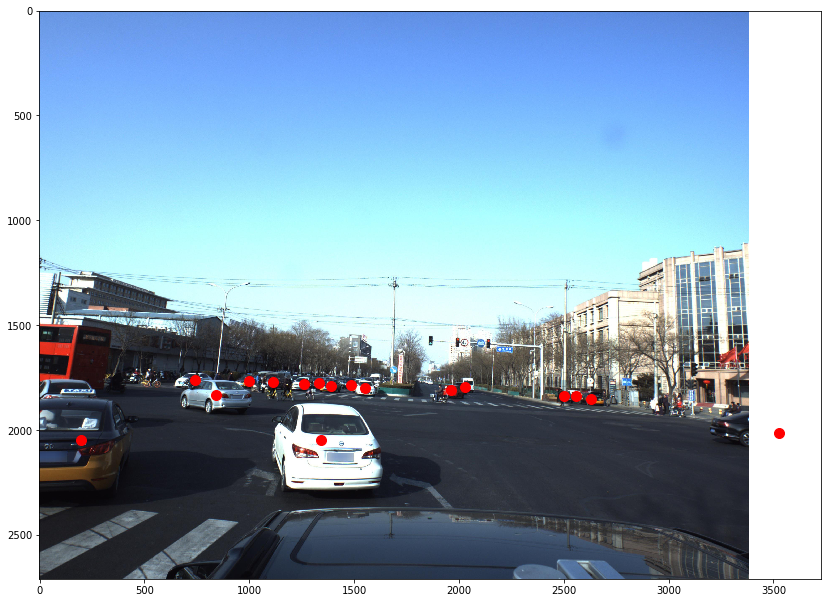

In [11]:
plt.figure(figsize=(14,14))
plt.imshow(imread(PATH + 'train_images/' + train['ImageId'][2217] + '.jpg'))
plt.scatter(*get_img_coords(train['PredictionString'][2217]), color='red', s=100);

In [12]:
def _regr_preprocess(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] / 100
    regr_dict['roll'] = rotate(regr_dict['roll'], np.pi)
    regr_dict['pitch_sin'] = sin(regr_dict['pitch'])
    regr_dict['pitch_cos'] = cos(regr_dict['pitch'])
    regr_dict.pop('pitch')
    regr_dict.pop('id')
    return regr_dict

def _regr_back(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] * 100
    regr_dict['roll'] = rotate(regr_dict['roll'], -np.pi)
    
    pitch_sin = regr_dict['pitch_sin'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    pitch_cos = regr_dict['pitch_cos'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    regr_dict['pitch'] = np.arccos(pitch_cos) * np.sign(pitch_sin)
    return regr_dict

def preprocess_image(img):
    img = img[img.shape[0] // 2:]
    bg = np.ones_like(img) * img.mean(1, keepdims=True).astype(img.dtype)
    bg = bg[:, :img.shape[1] // 4]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (img_w, img_h))
    return img

def get_mask_and_regr(img_orig_height, img_orig_width, labels):
    mask = np.zeros([img_h // model_scale, img_w // model_scale], dtype='float32')
    regr_names = ['x', 'y', 'z', 'yaw', 'pitch', 'roll']
    regr = np.zeros([img_h // model_scale, img_w // model_scale, 7], dtype='float32')
    coords = str2coords(labels)
    xs, ys = get_img_coords(labels)
    for x, y, regr_dict in zip(xs, ys, coords):
        x, y = y, x
        x = (x - img_orig_height // 2) * img_h / (img_orig_height // 2) / model_scale
        x = np.round(x).astype('int')
        y = (y + img_orig_width // 4) * img_w / (img_orig_width * 1.5) / model_scale
        y = np.round(y).astype('int')
        if x >= 0 and x < img_h // model_scale and y >= 0 and y < img_w // model_scale:
            mask[x, y] = 1
            regr_dict = _regr_preprocess(regr_dict)
            regr[x, y] = [regr_dict[n] for n in sorted(regr_dict)]
    return mask, regr

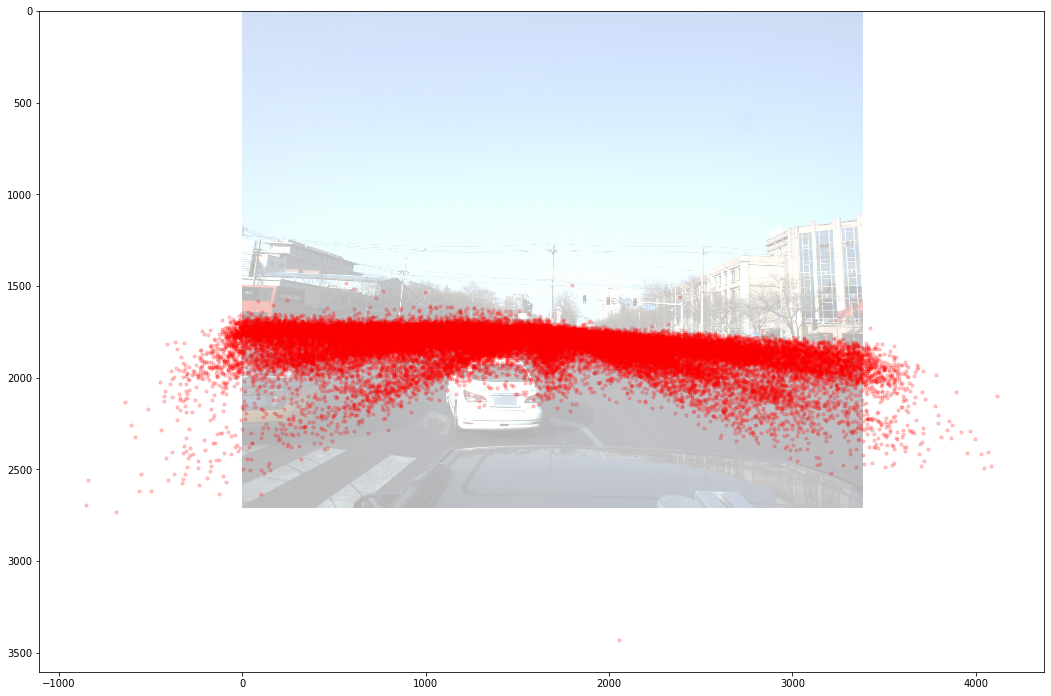

In [13]:
xs, ys = [], []

for ps in train['PredictionString']:
    x, y = get_img_coords(ps)
    xs += list(x)
    ys += list(y)

plt.figure(figsize=(18,18))
plt.imshow(imread(PATH + 'train_images/' + train['ImageId'][2217] + '.jpg'), alpha=0.3)
plt.scatter(xs, ys, color='red', s=10, alpha=0.2);

# Remove cars with coordinates outside the image boundaries
There are many cars coordinates that fall outside of image as noted in CenterNet Baseline kernel I remove them here from train

In [14]:
img_orig_h, img_orig_w = 2710, 3384

def remove_out_image_cars(df):

        def isnot_out(x,y):
            # are x,y coordinates within boundaries of the image
            return (x>=0)&(x<=img_orig_w)&(y>=0)&(y<=img_orig_h)

        df = add_number_of_cars(df)

        new_str_coords = []
        counter_all_ls = []
        for idx,str_coords in enumerate(df['PredictionString']):
            coords = str2coords(str_coords, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z'])
            xs, ys = get_img_coords(str_coords)
            counter = 0
            coords_new = []
            
            for (item,x,y) in zip(coords, xs, ys):
                if isnot_out(x, y):
                    coords_new.append(item)
                    counter += 1
                                
            new_str_coords.append(coords2str(coords_new,  names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']))
            counter_all_ls.append(counter)
            
        df['new_pred_string']  = new_str_coords 
        df['new_numcars'] = counter_all_ls

        print("num of cars outside image bounds:", df['numcars'].sum()-df['new_numcars'].sum(), 
            "out of all", df['numcars'].sum(), " cars in train")

        del df['PredictionString'], train['numcars'], train['new_numcars']
        df.rename(columns={'new_pred_string': 'PredictionString'}, inplace=True)

        return df
    
train = remove_out_image_cars(train)

num of cars outside image bounds: 997 out of all 49598  cars in train


# Assert that new car coordinates are within image boundaries

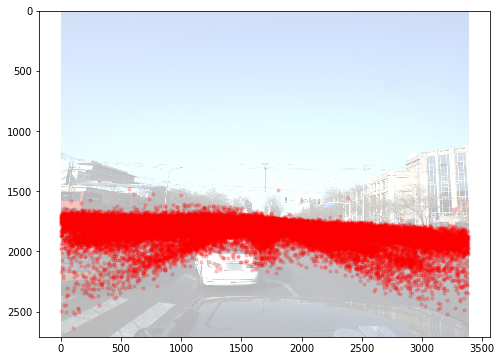

In [15]:
xs, ys = [], []
#train_image_idx =6
train_image_idx =2217

for ps in train['PredictionString']:
    x, y = get_img_coords(ps)
    xs += list(x)
    ys += list(y)

train_test_path = PATH
    
plt.figure(figsize=(12,6))
plt.imshow(imread(os.path.join(train_test_path,'train_images', train['ImageId'][train_image_idx] + '.jpg')), alpha=0.3)
plt.scatter(xs, ys, color='red', s=10, alpha=0.2);

# Albumentations augmentation
As noted in Discussions, test images have been augmented pixel-wise and with horizontal flip. Only pixel augmentations are applied here
https://qiita.com/Takayoshi_Makabe/items/79c8a5ba692aa94043f7

... skip ...

# 3D Visualization
Used code from https://www.kaggle.com/zstusnoopy/visualize-the-location-and-3d-bounding-box-of-car, but made it one function

In [16]:
from math import sin, cos

# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

In [17]:
def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image


def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
        cv2.circle(image, (p_x, p_y), int(1000 / p_z), (0, 255, 0), -1)
#         if p_x > image.shape[1] or p_y > image.shape[0]:
#             print('Point', p_x, p_y, 'is out of image with shape', image.shape)
    return image

In [18]:
def visualize(img, coords):
    # You will also need functions from the previous cells
    x_l = 1.02
    y_l = 0.80
    z_l = 2.31
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = point['x'], point['y'], point['z']
        yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
    
    return img

# Image preprocessing

In [19]:
IMG_WIDTH = 1600
IMG_HEIGHT = 700
MODEL_SCALE = 8

def _regr_preprocess(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] / 100
    regr_dict['roll'] = rotate(regr_dict['roll'], np.pi)
    regr_dict['pitch_sin'] = sin(regr_dict['pitch'])
    regr_dict['pitch_cos'] = cos(regr_dict['pitch'])
    regr_dict.pop('pitch')
    regr_dict.pop('id')
    return regr_dict

def _regr_back(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] * 100
    regr_dict['roll'] = rotate(regr_dict['roll'], -np.pi)
    
    pitch_sin = regr_dict['pitch_sin'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    pitch_cos = regr_dict['pitch_cos'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    regr_dict['pitch'] = np.arccos(pitch_cos) * np.sign(pitch_sin)
    return regr_dict

def preprocess_image(img):
    img = img[img.shape[0] // 2:]
    bg = np.ones_like(img) * img.mean(1, keepdims=True).astype(img.dtype)
    bg = bg[:, :img.shape[1] // 4]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    return (img / 255).astype('float32')

def get_mask_and_regr(img, labels):
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    regr_names = ['x', 'y', 'z', 'yaw', 'pitch', 'roll']
    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 7], dtype='float32')
    coords = str2coords(labels)
    xs, ys = get_img_coords(labels)
    for x, y, regr_dict in zip(xs, ys, coords):
        x, y = y, x
        x = (x - img.shape[0] // 2) * IMG_HEIGHT / (img.shape[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + img.shape[1] // 4) * IMG_WIDTH / (img.shape[1] * 1.5) / MODEL_SCALE
        y = np.round(y).astype('int')
        if x >= 0 and x < IMG_HEIGHT // MODEL_SCALE and y >= 0 and y < IMG_WIDTH // MODEL_SCALE:
            mask[x, y] = 1
            regr_dict = _regr_preprocess(regr_dict)
            regr[x, y] = [regr_dict[n] for n in sorted(regr_dict)]
    return mask, regr

img.shape (700, 1600, 3) std: 0.2870833
mask.shape (87, 200) std: 0.01694915
regr.shape (87, 200, 7) std: 0.0071668467


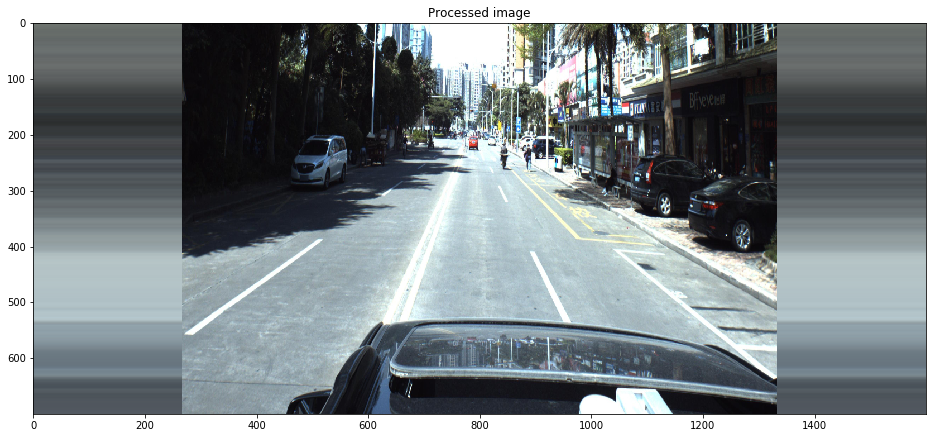

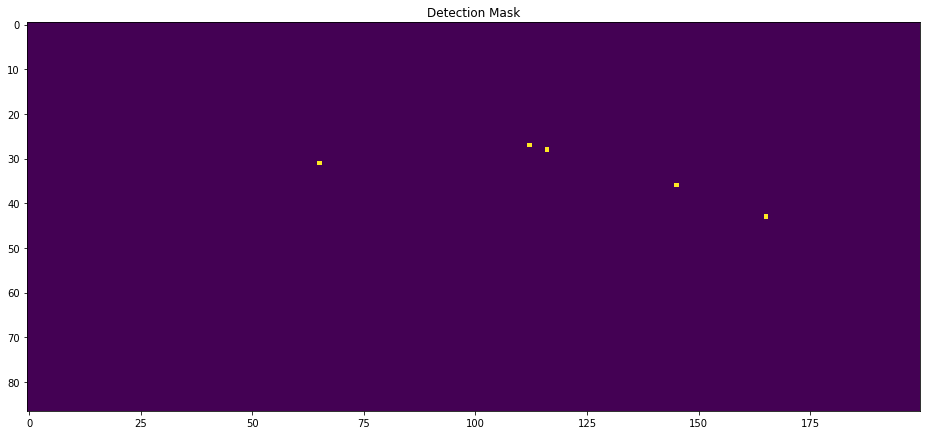

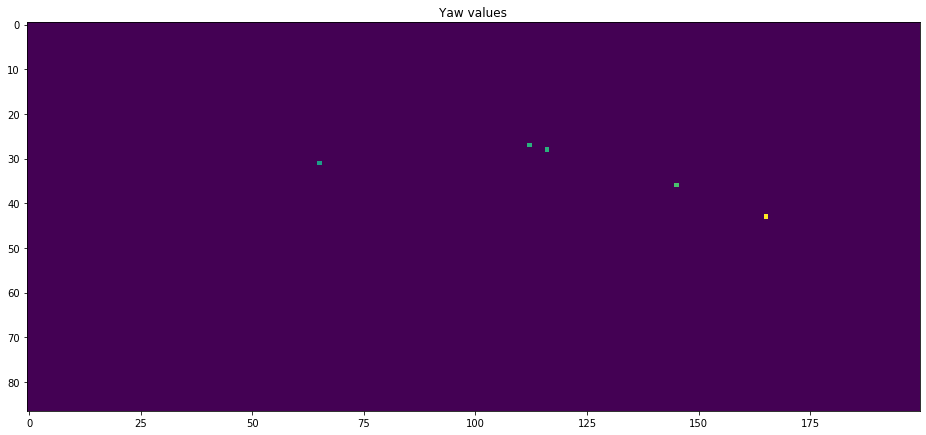

In [20]:
img0 = imread(PATH + 'train_images/' + train['ImageId'][0] + '.jpg')
img = preprocess_image(img0)

mask, regr = get_mask_and_regr(img0, train['PredictionString'][0])

print('img.shape', img.shape, 'std:', np.std(img))
print('mask.shape', mask.shape, 'std:', np.std(mask))
print('regr.shape', regr.shape, 'std:', np.std(regr))

plt.figure(figsize=(16,16))
plt.title('Processed image')
plt.imshow(img)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Detection Mask')
plt.imshow(mask)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Yaw values')
plt.imshow(regr[:,:,-2])
plt.show()

# PyTorch Dataset

In [21]:
class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, dataframe, root_dir, training=True, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.training = training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Get image name
        idx, labels = self.df.values[idx]
        img_name = self.root_dir.format(idx)
        
        # Read image
        img0 = imread(img_name, True)
        img = preprocess_image(img0)
        img = np.rollaxis(img, 2, 0)
        
        # Get mask and regression maps
        if self.training:
            mask, regr = get_mask_and_regr(img0, labels)
            regr = np.rollaxis(regr, 2, 0)
        else:
            mask, regr = 0, 0
        
        return [img, mask, regr]

In [22]:
train_images_dir = PATH + 'train_images/{}.jpg'
test_images_dir = PATH + 'test_images/{}.jpg'

df_train, df_dev = train_test_split(train, test_size=0.1, random_state=63)
df_test = test

# Create dataset objects
train_dataset = CarDataset(df_train, train_images_dir)
dev_dataset = CarDataset(df_dev, train_images_dir)
test_dataset = CarDataset(df_test, test_images_dir)

Show some generated examples

In [23]:
#train_dataset[0]
train

ImageId                                   PredictionString
0     ID_8a6e65317  16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1     ID_337ddc495  66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2     ID_a381bf4d0  43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3     ID_7c4a3e0aa  43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4     ID_8b510fad6  37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...
...            ...                                                ...
4257  ID_de17ab626  70 0.177583 -0.023215 -3.08003 -25.3682 7.5732...
4258  ID_5a669e211  12 0.23817 -3.12745 3.13929 -7.21988 3.09626 1...
4259  ID_aa6ffba0a  35 0.166437 -0.497963 -3.12063 12.6792 5.48256...
4260  ID_29454123f  70 0.14292 0.0290822 -3.12594 -3.42749 3.38674...
4261  ID_2dee4d6e6  35 0.166939 3.08081 -3.11637 -14.8892 6.55844 ...

[4253 rows x 2 columns]

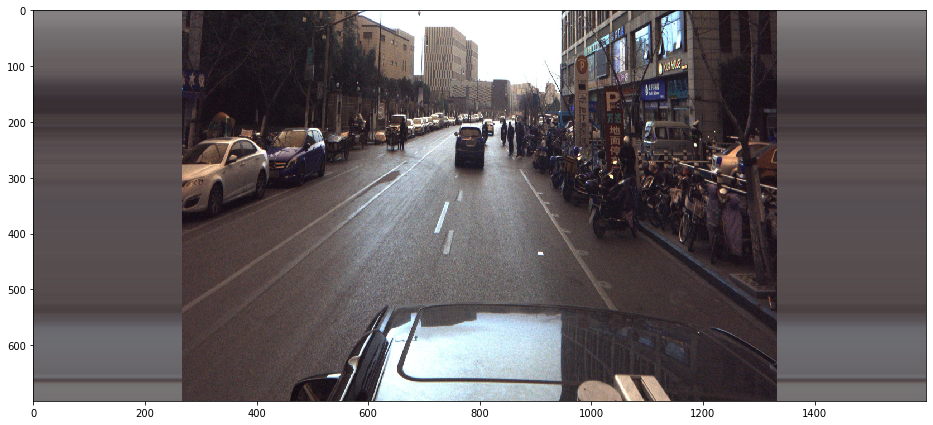

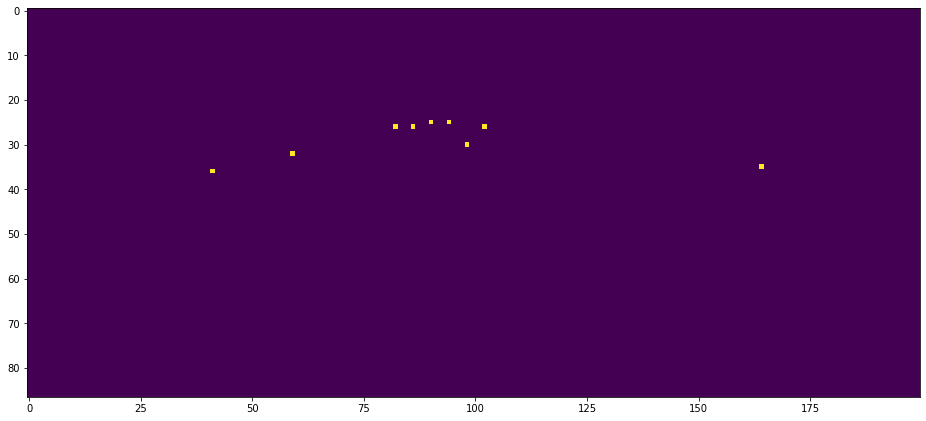

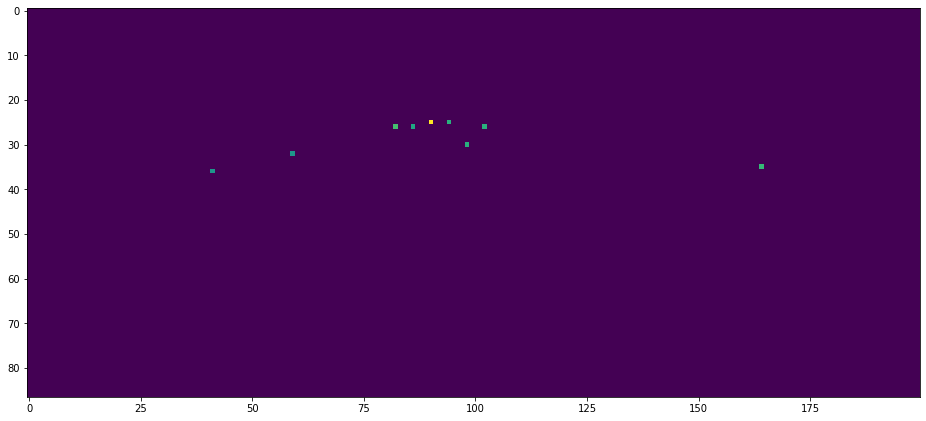

In [24]:
img, mask, regr = train_dataset[0]

plt.figure(figsize=(16,16))
plt.imshow(np.rollaxis(img, 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(mask)
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(regr[-2])
plt.show()

In [25]:
BATCH_SIZE = 1

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# PyTorch Model

In [26]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

**ResneXt**

In [27]:


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'densenet201': 'https://download.pytorch.org/models/densenet201-c1103571.pth',
    'inceptionresnetv2': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.GroupNorm(16, planes)

        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.GroupNorm(16, planes)

        if stride != 1 or inplanes != planes:
            self.downsample = nn.Sequential(
                conv1x1(inplanes, planes, stride), nn.GroupNorm(16, planes))
        else:
            self.downsample = None


    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out, inplace=True)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.GroupNorm(16, planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.GroupNorm(16, planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.GroupNorm(16, planes * self.expansion)

        if stride != 1 or inplanes != planes * self.expansion:
            self.downsample = nn.Sequential(
                conv1x1(inplanes, planes * self.expansion, stride), 
                nn.GroupNorm(16, planes * self.expansion))
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = F.relu(self.bn2(self.conv2(out)), inplace=True)
        out = self.bn3(self.conv3(out))
 
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out


class ResNetFeatures(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNetFeatures, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.GroupNorm(16, 64)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):

        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        conv1 = F.relu(self.bn1(self.conv1(x)), inplace=True)
        conv1 = F.max_pool2d(conv1, 3, stride=2, padding=1)

        feats4 = self.layer1(conv1)
        feats8 = self.layer2(feats4)
        feats16 = self.layer3(feats8)
        feats32 = self.layer4(feats16)

        return feats8, feats16, feats32


'''
def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnet18']))
    return model
'''

def  resnext50(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnext50_32x4d']))
    return model
'''

def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnet34']))
    return model

def inceptionresnetv2(pretrained=False, **kwargs):
    """Constructs a inceptionresnetv2.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['inceptionresnetv2']))
    return model

def densenet201(pretrained=False, **kwargs):
    """Constructs a densenet201 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['densenet201']))
    return model


def _load_pretrained(model, pretrained):
    model_dict = model.state_dict()
    pretrained = {k : v for k, v in pretrained.items() if k in model_dict}
    model_dict.update(pretrained)
    model.load_state_dict(model_dict)
'''

'\n\ndef resnet34(pretrained=False, **kwargs):\n    """Constructs a ResNet-34 model.\n    Args:\n        pretrained (bool): If True, returns a model pre-trained on ImageNet\n    """\n    model = ResNetFeatures(BasicBlock, [3, 4, 6, 3], **kwargs)\n    if pretrained:\n        _load_pretrained(model, model_zoo.load_url(model_urls[\'resnet34\']))\n    return model\n\ndef inceptionresnetv2(pretrained=False, **kwargs):\n    """Constructs a inceptionresnetv2.\n    Args:\n        pretrained (bool): If True, returns a model pre-trained on ImageNet\n    """\n    model = ResNetFeatures(BasicBlock, [3, 4, 6, 3], **kwargs)\n    if pretrained:\n        _load_pretrained(model, model_zoo.load_url(model_urls[\'inceptionresnetv2\']))\n    return model\n\ndef densenet201(pretrained=False, **kwargs):\n    """Constructs a densenet201 model.\n    Args:\n        pretrained (bool): If True, returns a model pre-trained on ImageNet\n    """\n    model = ResNetFeatures(BasicBlock, [3, 4, 6, 3], **kwargs)\n    if

**Why resnext50 instead of resnet?**

![](https://pytorch.org/assets/images/resnext.png)

So a resnext_32*4d represents network with 4 bottleneck [one block in the above diagram] layers, and each layer having cardinality of 32.

**ResNeXt Architecture Review**

ResNeXt won 2nd place in ILSVRC 2016 classification task and also showed performance improvements in Coco detection and ImageNet-5k set than their ResNet counter part.

This is a very simple paper to read which introduces a new term called “cardinality”. The paper simply explains this term and make use of it in ResNet networks and does various ablation studies.

The paper made several attempts to describe the complexity of Inception networks and why ResNeXt architecture is simple. I m not going to do this here as it would require the reader to understand Inception networks. I will just talk about the architecture here.

![](https://miro.medium.com/max/965/1*mdiQTfovOXKnqzfj727b9Q.png)

* The above diagram distinguishes between a simple ResNet block and ResNeXt blog.
* It follows a split-transform-aggregate strategy.
* The number of paths inside the ResNeXt block is defined as cardinality. In the above diagram C=32
* All the paths contain the same topology.
* Instead of having high depth and width, Having high cardinality helps in decreasing validation error.
* ResNeXt tries embed more subspaces compared to its ResNet counter part.
* Both the architectures have different width. Layer-1 in ResNet has one conv layer with 64 width, while layer-1 in ResNext has 32 different conv layers with 4 width (32*4 width). Despite the larger overall width in ResNeXt, both the architectures have the same number of parameters(~70k) (ResNet 256*64+3*3*64*64+64*26) (ResNeXt C*(256*d+3*3*d*d+d*256), with C=32 and d=4)

**Cardinality vs width: with C increasing from 1 to 32, we can clearly see a descrease in top-1 % error rate. Therefore, Increasing the C by decreasing the width has improved the performance of the model.**

![](https://miro.medium.com/max/614/1*VmsRr6jis0Sg7asAfAT1LQ.png)

**Increasing Cardinality vs Deeper/Wider:**

Basically 3 cases were studied. 1) Increasing the number of layers to 200 from 101. 2) Going wider by increasing the bottleneck width. 3) Increasing cardinality by doubling C.

They have observed that increasing the C gave better performance improvements. below are the results.

![](https://miro.medium.com/max/638/1*t4CD5LCb-4TtFgXry-Sndg.png)

**An ensemble of different ResNeXt architecture gave a top-5 error rate of 3.03% thus winning second position in ILSVRC competition.
The architecture is simple in design compared to Inception modules.**

** Inception-ResNet-V2 (2016)**

![](https://miro.medium.com/max/3750/1*xpb6QFQ4IknSmxmgai8w-Q.png)

In [28]:
base_model = resnext50(pretrained=False)
base_model

ResNetFeatures(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): GroupNorm(16, 64, eps=1e-05, affine=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): GroupNorm(16, 64, eps=1e-05, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): GroupNorm(16, 64, eps=1e-05, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): GroupNorm(16, 64, eps=1e-05, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): GroupNorm(16, 64, eps=1e-05, affine=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): GroupNorm(16, 128, 

In [29]:
class CentResnet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(CentResnet, self).__init__()
        self.base_model = base_model
        
        # Lateral layers convert resnet outputs to a common feature size
        self.lat8 = nn.Conv2d(128, 256, 1)
        self.lat16 = nn.Conv2d(256, 256, 1)
        self.lat32 = nn.Conv2d(512, 256, 1)
        self.bn8 = nn.GroupNorm(16, 256)
        self.bn16 = nn.GroupNorm(16, 256)
        self.bn32 = nn.GroupNorm(16, 256)

       
        self.conv0 = double_conv(5, 64)
        self.conv1 = double_conv(64, 128)
        self.conv2 = double_conv(128, 512)
        self.conv3 = double_conv(512, 1024)
        
        self.mp = nn.MaxPool2d(2)
        
        self.up1 = up(1282 , 512) #+ 1024
        self.up2 = up(512 + 512, 256)
        self.outc = nn.Conv2d(256, n_classes, 1)
        
    
    def forward(self, x):
        batch_size = x.shape[0]
        mesh1 = get_mesh(batch_size, x.shape[2], x.shape[3])
        x0 = torch.cat([x, mesh1], 1)
        x1 = self.mp(self.conv0(x0))
        x2 = self.mp(self.conv1(x1))
        x3 = self.mp(self.conv2(x2))
        x4 = self.mp(self.conv3(x3))
        
        #feats = self.base_model.extract_features(x)
                # Run frontend network
        feats8, feats16, feats32 = self.base_model(x)
        lat8 = F.relu(self.bn8(self.lat8(feats8)))
        lat16 = F.relu(self.bn16(self.lat16(feats16)))
        lat32 = F.relu(self.bn32(self.lat32(feats32)))
        
        # Add positional info
        mesh2 = get_mesh(batch_size, lat32.shape[2], lat32.shape[3])
        feats = torch.cat([lat32, mesh2], 1)
        #print(feats.shape)
        #print (x4.shape)
        x = self.up1(feats, x4)
        x = self.up2(x, x3)
        x = self.outc(x)
        return x

# Radam

In [30]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

In [31]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#n_epochs = 2 #original 10, 8, 7
n_epochs = 10 #original 10, 8, 7

model = CentResnet(8).to(device)

######################
#print("load model")
#model.load_state_dict(torch.load('./resnext50-ep10-0.047.pth'))
######################


optimizer = optim.AdamW(model.parameters(), lr=0.001)
#optimizer =  RAdam(model.parameters(), lr = 0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=max(n_epochs, 10) * len(train_loader) // 3, gamma=0.1)

cuda


In [32]:
img_batch = torch.randn((1,3,700,1600))

In [33]:
test = model(img_batch.to(device))

# Training

In [34]:
def criterion(prediction, mask, regr,weight=0.4, size_average=True):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0])
#     mask_loss = mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - mask) * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)
    mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    mask_loss = -mask_loss.mean(0).sum()
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
    regr_loss = regr_loss.mean(0)
  
    # Sum
    loss = mask_loss +regr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss ,mask_loss , regr_loss

In [35]:
## Just for checking the shapes to manage our Unet
i = 0
for batch_idx, (img_batch, mask_batch, regr_batch) in enumerate(tqdm(train_loader)):
    print(img_batch.shape)
    print(mask_batch.shape)
    print(regr_batch.shape)
    i+=1
    if i>1:
        break 

torch.Size([1, 3, 700, 1600])
torch.Size([1, 87, 200])
torch.Size([1, 7, 87, 200])
torch.Size([1, 3, 700, 1600])
torch.Size([1, 87, 200])
torch.Size([1, 7, 87, 200])


In [36]:
def train(epoch, history=None):
    model.train()
    t = tqdm(train_loader)
    for batch_idx, (img_batch, mask_batch, regr_batch) in enumerate(t):
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        output = model(img_batch)
        if epoch < SWITCH_LOSS_EPOCH :
            loss,mask_loss, regr_loss = criterion(output, mask_batch, regr_batch,1)
        else:
            loss,mask_loss, regr_loss = criterion(output, mask_batch, regr_batch,0.5)  
        
        t.set_description(f'train_loss (l={loss:.3f})(m={mask_loss:.2f}) (r={regr_loss:.4f}')
        
        if history is not None:
            history.loc[epoch + batch_idx / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
        
        loss.backward()
        
        optimizer.step()
        exp_lr_scheduler.step()

    
    print('Train Epoch: {} \tLR: {:.6f}\tLoss: {:.6f}\tMaskLoss: {:.6f}\tRegLoss: {:.6f}'.format(
        epoch,
        optimizer.state_dict()['param_groups'][0]['lr'],
        loss.data,
        mask_loss.data,
        regr_loss.data))

def evaluate(epoch, history=None):
    model.eval()
    loss = 0
    valid_loss = 0
    valid_mask_loss = 0
    valid_regr_loss = 0
    with torch.no_grad():
        for img_batch, mask_batch, regr_batch in dev_loader:
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_batch = regr_batch.to(device)

            output = model(img_batch)

            if epoch < SWITCH_LOSS_EPOCH :
                loss,mask_loss, regr_loss= criterion(output, mask_batch, regr_batch,1, size_average=False)
                valid_loss += loss.data
                valid_mask_loss += mask_loss.data
                valid_regr_loss += regr_loss.data
            else :
                loss,mask_loss, regr_loss = criterion(output, mask_batch, regr_batch,0.5, size_average=False)
                valid_loss += loss.data
                valid_mask_loss += mask_loss.data
                valid_regr_loss += regr_loss.data 

    
    valid_loss /= len(dev_loader.dataset)
    valid_mask_loss /= len(dev_loader.dataset)
    valid_regr_loss /= len(dev_loader.dataset)
    
    if history is not None:
        history.loc[epoch, 'dev_loss'] = valid_loss.cpu().numpy()
        history.loc[epoch, 'mask_loss'] = valid_mask_loss.cpu().numpy()
        history.loc[epoch, 'regr_loss'] = valid_regr_loss.cpu().numpy()

    
    print('Dev loss: {:.4f}'.format(valid_loss))

In [64]:
subprocess.call('rm -f ./charts/*', shell=True)
subprocess.call('rm -f ./resnext50-e*.pth', shell=True)

0

In [65]:
%%time
import gc

history = pd.DataFrame()

for epoch in range(n_epochs):
    pth_file=f'./resnext50-e{epoch:02}.pth'
    print(pth_file)
    torch.cuda.empty_cache()
    gc.collect()
    train(epoch, history)
    evaluate(epoch, history)
    torch.save(model.state_dict(), pth_file)

    # loss charts
    plr.clf()
    history['train_loss'].iloc[100:].plot(color='blue')
    plt.savefig(f'./charts/train_loss-e{epoch:02}.jpg')
    
    plt.clf()
    series1 = history.dropna()['mask_loss']
    plt.plot(series1.index, series1 ,label = 'mask loss', color='red')
    series2 = history.dropna()['regr_loss']
    plt.plot(series2.index, 30*series2,label = 'regr loss', color='green')
    series3 = history.dropna()['dev_loss']
    plt.plot(series3.index, series3,label = 'dev loss', color='blue')
    #plt.show()
    plt.savefig(f'./charts/mask-regr-dev-e{epoch:02}.jpg')

./resnext50-e00.pth


KeyboardInterrupt: 

In [ ]:
#torch.save(model.state_dict(), './resnext50.pth')

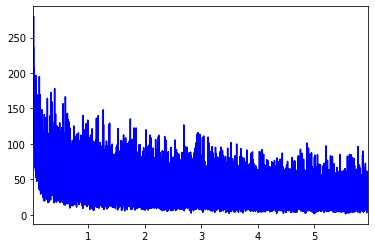

In [53]:
history['train_loss'].iloc[100:].plot(color='blue');

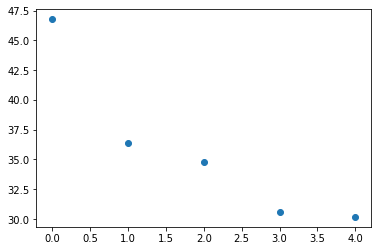

In [52]:
series = history.dropna()['dev_loss']
plt.scatter(series.index, series);
plt.savefig(f'./charts/dev_loss-e{epoch:02}.jpg');

# Visualize predictions

In [ ]:
img, mask, regr = dev_dataset[0]

plt.figure(figsize=(16,16))
plt.title('Input image')
plt.imshow(np.rollaxis(img, 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.title('Ground truth mask')
plt.imshow(mask)
plt.show()

output = model(torch.tensor(img[None]).to(device))
logits = output[0,0].data.cpu().numpy()

plt.figure(figsize=(16,16))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

print(logits)
plt.figure(figsize=(16,16))
plt.title('Model predictions thresholded')
plt.imshow(logits > 0)
plt.show()

In [ ]:
## Simple test of probabilities
act = torch.nn.Sigmoid()
logtens = torch.from_numpy(logits)
probs = act(logtens)
probs = probs[probs>0]
print(probs)

In [ ]:
DISTANCE_THRESH_CLEAR = 2

def convert_3d_to_2d(x, y, z, fx = 2304.5479, fy = 2305.8757, cx = 1686.2379, cy = 1354.9849):
    # stolen from https://www.kaggle.com/theshockwaverider/eda-visualization-baseline
    return x * fx / z + cx, y * fy / z + cy

def optimize_xy(r, c, x0, y0, z0):
    def distance_fn(xyz):
        x, y, z = xyz
        x, y = convert_3d_to_2d(x, y, z0)
        y, x = x, y
        x = (x - IMG_SHAPE[0] // 2) * IMG_HEIGHT / (IMG_SHAPE[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + IMG_SHAPE[1] // 4) * IMG_WIDTH / (IMG_SHAPE[1] * 1.5) / MODEL_SCALE
        y = np.round(y).astype('int')
        return (x-r)**2 + (y-c)**2
    
    res = minimize(distance_fn, [x0, y0, z0], method='Powell')
    x_new, y_new, z_new = res.x
    return x_new, y_new, z0

def clear_duplicates(coords):
    for c1 in coords:
        xyz1 = np.array([c1['x'], c1['y'], c1['z']])
        for c2 in coords:
            xyz2 = np.array([c2['x'], c2['y'], c2['z']])
            distance = np.sqrt(((xyz1 - xyz2)**2).sum())
            if distance < DISTANCE_THRESH_CLEAR:
                if c1['confidence'] < c2['confidence']:
                    c1['confidence'] = -1
    return [c for c in coords if c['confidence'] > 0]

def extract_coords(prediction):
    logits = prediction[0]
    regr_output = prediction[1:]
    points = np.argwhere(logits > 0)
    col_names = sorted(['x', 'y', 'z', 'yaw', 'pitch_sin', 'pitch_cos', 'roll'])
    coords = []
    for r, c in points:
        regr_dict = dict(zip(col_names, regr_output[:, r, c]))
        coords.append(_regr_back(regr_dict))
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[r, c]))
        coords[-1]['x'], coords[-1]['y'], coords[-1]['z'] = optimize_xy(r, c, coords[-1]['x'], coords[-1]['y'], coords[-1]['z'])
    coords = clear_duplicates(coords)
    return coords

def coords2str(coords, names=['yaw', 'pitch', 'roll', 'x', 'y', 'z', 'confidence']):
    s = []
    for c in coords:
        for n in names:
            s.append(str(c.get(n, 0)))
    return ' '.join(s)

In [ ]:
torch.cuda.empty_cache()
gc.collect()

for idx in range(4):
    img, mask, regr = dev_dataset[idx]
    
    output = model(torch.tensor(img[None]).to(device)).data.cpu().numpy()
    coords_pred = extract_coords(output[0])
    coords_true = extract_coords(np.concatenate([mask[None], regr], 0))
    
    img = imread(train_images_dir.format(df_dev['ImageId'].iloc[idx]))
    
    fig, axes = plt.subplots(1, 2, figsize=(30,30))
    axes[0].set_title('Ground truth')
    axes[0].imshow(visualize(img, coords_true))
    axes[1].set_title('Prediction')
    axes[1].imshow(visualize(img, coords_pred))
    plt.show()

# Make submission

In [ ]:
# taken from kernel of @its7171 
val_preds = []

#dev_loader = DataLoader(dataset=dev_dataset, batch_size=4, shuffle=False, num_workers=4)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=1, shuffle=False, num_workers=0)

model.eval()

for img, _, _ in tqdm(dev_loader):
    with torch.no_grad():
        output = model(img.to(device))
    output = output.data.cpu().numpy()
    for out in output:
        coords = extract_coords(out)
        s = coords2str(coords)
        val_preds.append(s)

In [ ]:
!df -h

In [ ]:
df_dev['PredictionString'] = val_preds
df_dev.head()
df_dev.to_csv('val_predictions.csv', index=False)

In [ ]:
predictions = []

#test_loader = DataLoader(dataset=test_dataset, batch_size=2, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=0)

model.eval()

for img, _, _ in tqdm(test_loader):
    with torch.no_grad():
        output = model(img.to(device))
    output = output.data.cpu().numpy()
    for out in output:
        coords = extract_coords(out)
        s = coords2str(coords)
        predictions.append(s)

In [ ]:
test = pd.read_csv(PATH + 'sample_submission.csv')
test['PredictionString'] = predictions
test.to_csv('predictions.csv', index=False)
test.head()

In [ ]:

def expand_df(df, PredictionStringCols):
    df = df.dropna().copy()
    df['NumCars'] = [int((x.count(' ')+1)/7) for x in df['PredictionString']]

    image_id_expanded = [item for item, count in zip(df['ImageId'], df['NumCars']) for i in range(count)]
    prediction_strings_expanded = df['PredictionString'].str.split(' ',expand = True).values.reshape(-1,7).astype(float)
    prediction_strings_expanded = prediction_strings_expanded[~np.isnan(prediction_strings_expanded).all(axis=1)]
    df = pd.DataFrame(
        {
            'ImageId': image_id_expanded,
            PredictionStringCols[0]:prediction_strings_expanded[:,0],
            PredictionStringCols[1]:prediction_strings_expanded[:,1],
            PredictionStringCols[2]:prediction_strings_expanded[:,2],
            PredictionStringCols[3]:prediction_strings_expanded[:,3],
            PredictionStringCols[4]:prediction_strings_expanded[:,4],
            PredictionStringCols[5]:prediction_strings_expanded[:,5],
            PredictionStringCols[6]:prediction_strings_expanded[:,6]
        })
    return df

def str2coords(s, names):
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
    return coords

def TranslationDistance(p,g, abs_dist = False):
    dx = p['x'] - g['x']
    dy = p['y'] - g['y']
    dz = p['z'] - g['z']
    diff0 = (g['x']**2 + g['y']**2 + g['z']**2)**0.5
    diff1 = (dx**2 + dy**2 + dz**2)**0.5
    if abs_dist:
        diff = diff1
    else:
        diff = diff1/diff0
    return diff

def RotationDistance(p, g):
    true=[ g['pitch'] ,g['yaw'] ,g['roll'] ]
    pred=[ p['pitch'] ,p['yaw'] ,p['roll'] ]
    q1 = R.from_euler('xyz', true)
    q2 = R.from_euler('xyz', pred)
    diff = R.inv(q2) * q1
    W = np.clip(diff.as_quat()[-1], -1., 1.)
    
    # in the official metrics code:
    # https://www.kaggle.com/c/pku-autonomous-driving/overview/evaluation
    #   return Object3D.RadianToDegree( Math.Acos(diff.W) )
    # this code treat θ and θ+2π differntly.
    # So this should be fixed as follows.
    W = (acos(W)*360)/pi
    if W > 180:
        W = 360 - W
    return W

In [ ]:
thres_tr_list = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
thres_ro_list = [50, 45, 40, 35, 30, 25, 20, 15, 10, 5]

def check_match(idx):
    keep_gt=False
    thre_tr_dist = thres_tr_list[idx]
    thre_ro_dist = thres_ro_list[idx]
    train_dict = {imgID:str2coords(s, names=['carid_or_score', 'pitch', 'yaw', 'roll', 'x', 'y', 'z']) for imgID,s in zip(train_df['ImageId'],train_df['PredictionString'])}
    valid_dict = {imgID:str2coords(s, names=['pitch', 'yaw', 'roll', 'x', 'y', 'z', 'carid_or_score']) for imgID,s in zip(valid_df['ImageId'],valid_df['PredictionString'])}
    result_flg = [] # 1 for TP, 0 for FP
    scores = []
    MAX_VAL = 10**10
    for img_id in valid_dict:
        for pcar in sorted(valid_dict[img_id], key=lambda x: -x['carid_or_score']):
            # find nearest GT
            min_tr_dist = MAX_VAL
            min_idx = -1
            for idx, gcar in enumerate(train_dict[img_id]):
                tr_dist = TranslationDistance(pcar,gcar)
                if tr_dist < min_tr_dist:
                    min_tr_dist = tr_dist
                    min_ro_dist = RotationDistance(pcar,gcar)
                    min_idx = idx
                    
            # set the result
            if min_tr_dist < thre_tr_dist and min_ro_dist < thre_ro_dist:
                if not keep_gt:
                    train_dict[img_id].pop(min_idx)
                result_flg.append(1)
            else:
                result_flg.append(0)
            scores.append(pcar['carid_or_score'])
    
    return result_flg, scores

In [ ]:
#validation_prediction = df_dev
valid_df = pd.read_csv('val_predictions.csv')
expanded_valid_df = expand_df(valid_df, ['pitch','yaw','roll','x','y','z','Score'])
valid_df = valid_df.fillna('')

train_df = pd.read_csv('../input/pku-autonomous-driving/train.csv')
train_df = train_df[train_df.ImageId.isin(valid_df.ImageId.unique())]
# data description page says, The pose information is formatted as
# model type, yaw, pitch, roll, x, y, z
# but it doesn't, and it should be
# model type, pitch, yaw, roll, x, y, z
expanded_train_df = expand_df(train_df, ['model_type','pitch','yaw','roll','x','y','z'])

max_workers = 10
n_gt = len(expanded_train_df)
ap_list = []
p = Pool(processes=max_workers)
for result_flg, scores in p.imap(check_match, range(10)):
    if np.sum(result_flg) > 0:
        n_tp = np.sum(result_flg)
        recall = n_tp/n_gt
        ap = average_precision_score(result_flg, scores)*recall
    else:
        ap = 0
    ap_list.append(ap)
map = np.mean(ap_list)
print('map:', map)